In [89]:

!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('17iO0rBs-gOFSUPbr6nd3IyfcKR-j2yYa')

In [90]:

!pip install jovian --upgrade --quiet

In [91]:

import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [92]:

batch_size=16
learning_rate=5e-7



DATASET_URL = "https://data.world/nrippner/ols-regression-challenge/file/cancer_reg.csv"
DATA_FILENAME = "cancer.csv"
TARGET_COLUMN = 'target_deathrate'
input_size=13
output_size=1

In [93]:
# Download the data
#download_url(DATASET_URL, '.')
dataframe = pd.read_csv(r'C:\Users\b\Downloads\cancer_reg.csv', encoding = "ISO-8859-1")
dataframe = dataframe[['avgAnnCount', 'avgDeathsPerYear', 'TARGET_deathRate', 'incidenceRate', 'povertyPercent', 'MedianAge', 'PctEmpPrivCoverage', 'PctPublicCoverage', 'PctWhite', 'PctBlack', 'PctAsian', 'PctOtherRace', 'PctMarriedHouseholds', 'BirthRate']]
dataframe.isnull().sum().sum()


0

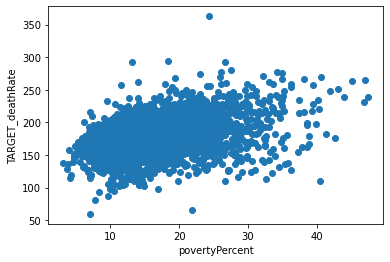

In [94]:
plt.scatter(dataframe['povertyPercent'], dataframe['TARGET_deathRate'])
plt.xlabel('povertyPercent')
plt.ylabel('TARGET_deathRate')
plt.show()

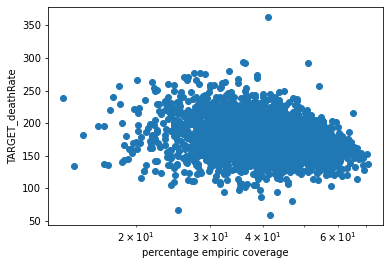

In [95]:
plt.scatter(dataframe['PctEmpPrivCoverage'], dataframe['TARGET_deathRate'])
plt.xlabel('percentage empiric coverage')
plt.ylabel('TARGET_deathRate')
plt.xscale('log')

plt.show()

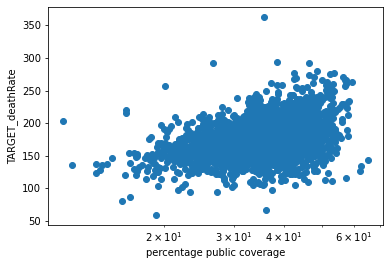

In [96]:

plt.scatter(dataframe['PctPublicCoverage'], dataframe['TARGET_deathRate'])
plt.xlabel('percentage public coverage')
plt.ylabel('TARGET_deathRate')
plt.xscale('log')
plt.show()

In [97]:

inputs = dataframe.drop('TARGET_deathRate', axis=1).values
targets = dataframe[['TARGET_deathRate']].values
inputs.shape, targets.shape
rown = dataframe.shape[0]
0.8 * rown, 0.2 * rown

(2437.6, 609.4)

In [98]:

dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))

train_ds, val_ds = random_split(dataset, [2437, 610])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

In [99]:
input_size = 13
output_size = 1

In [ ]:
!pip install jovian --upgrade --quiet
import jovian
jovian.commit(project='us-counties-cancer-death-rate-prediction')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..


In [77]:
class LifeExpectancyModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 64)
        self.linear3 = nn.Linear(64, 128)
        # output layer
        self.linear4 = nn.Linear(128, out_size)
        
    def forward(self, xb):

        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                  # Generate predictions
        loss = F.l1_loss(out, targets) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                    # Generate predictions
        loss = F.l1_loss(out, targets)   # Calculate loss
        acc = accuracy(out, targets)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))


In [78]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [79]:
model = LifeExpectancyModel(13, 32, 1)

In [80]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history


In [82]:
result = evaluate(model, val_loader)
result

{'val_loss': 188.2009735107422}

In [83]:
epochs = 100
lr = 1e-5

In [84]:
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 18.2967
Epoch [40], val_loss: 17.3733
Epoch [60], val_loss: 17.5189
Epoch [80], val_loss: 16.7627
Epoch [100], val_loss: 16.5373


In [42]:
epochs = 200
lr = 1e-5
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 16.2287
Epoch [40], val_loss: 15.8372
Epoch [60], val_loss: 16.7062
Epoch [80], val_loss: 15.3236
Epoch [100], val_loss: 14.5725
Epoch [120], val_loss: 14.1041
Epoch [140], val_loss: 14.3879
Epoch [160], val_loss: 12.3900
Epoch [180], val_loss: 11.9010
Epoch [200], val_loss: 13.0444


In [44]:
epochs = 300
lr = 1e-7
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 11.2609
Epoch [40], val_loss: 11.2581
Epoch [60], val_loss: 11.2514
Epoch [80], val_loss: 11.2451
Epoch [100], val_loss: 11.2421
Epoch [120], val_loss: 11.2348
Epoch [140], val_loss: 11.2223
Epoch [160], val_loss: 11.2354
Epoch [180], val_loss: 11.2146
Epoch [200], val_loss: 11.2053
Epoch [220], val_loss: 11.2143
Epoch [240], val_loss: 11.2146
Epoch [260], val_loss: 11.1926
Epoch [280], val_loss: 11.2045
Epoch [300], val_loss: 11.2065


In [ ]:
loss_final = 

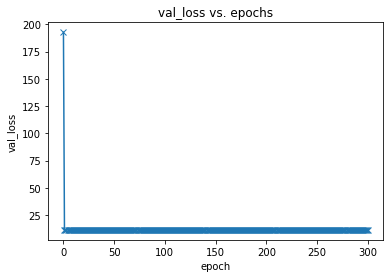

In [45]:
losses = [r['val_loss'] for r in [result] + history1 + history2 + history3]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

## Prediction

In [49]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [50]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([215.0000,  72.0000, 507.3000,  10.9000,  35.8000,  58.1000,  24.8000,
         88.5946,   5.1855,   0.8789,   2.6705,  56.8102,   5.2582])
Target:  179.60000610351562
Prediction: 164.47369384765625


In [51]:
for i in range(100, 200):
    x, target = val_ds[i]
    pred = predict_single(x, model)
    print("Input: ", x)
    print("Target: ", target.item())
    print("Prediction:", pred)
    print('\n\n')

Input:  tensor([1.2300e+02, 5.5000e+01, 4.8380e+02, 1.7000e+01, 4.9300e+01, 3.2900e+01,
        4.8400e+01, 7.8220e+01, 6.9162e-01, 4.3075e-01, 5.8849e-01, 5.1338e+01,
        4.2723e+00])
Target:  208.5
Prediction: 200.4563751220703



Input:  tensor([2.3000e+01, 9.0000e+00, 4.9240e+02, 1.1600e+01, 4.8000e+01, 3.2000e+01,
        2.9500e+01, 9.5627e+01, 0.0000e+00, 3.3636e-02, 0.0000e+00, 6.0494e+01,
        7.2464e+00])
Target:  166.5
Prediction: 183.65469360351562



Input:  tensor([163.0000,  65.0000, 503.8000,  11.0000,  39.1000,  50.7000,  30.2000,
         66.0602,  29.2582,   0.8075,   1.1857,  51.5861,   4.3845])
Target:  201.8000030517578
Prediction: 188.7680206298828



Input:  tensor([168.0000,  71.0000, 534.0000,  19.7000,  40.2000,  40.3000,  34.9000,
         85.0878,   8.9827,   1.2220,   3.3473,  52.2609,   5.5083])
Target:  227.1999969482422
Prediction: 213.11216735839844



Input:  tensor([1069.0000,  371.0000,  491.6000,   13.1000,   39.7000,   52.7000,
          32

In [ ]:
torch.save(model.state_dict(), 'cancer-rate-feedforward.pth')

In [88]:
jovian.log_metrics(final_loss = loss_final, hidden_layers = 3, lr1 = 1e-5, epoch1 = 100, lr2 = 1e-5, epoch2 = 200, lr3 = 1e-5, epoch3 =300)

NameError: name 'loss_final' is not defined

In [ ]:
jovian.commit(project='us-counties-cancer-death-rate-prediction', 
              environment=None, 
              outputs=['cancer-rate-feedforward.pth'])